# 

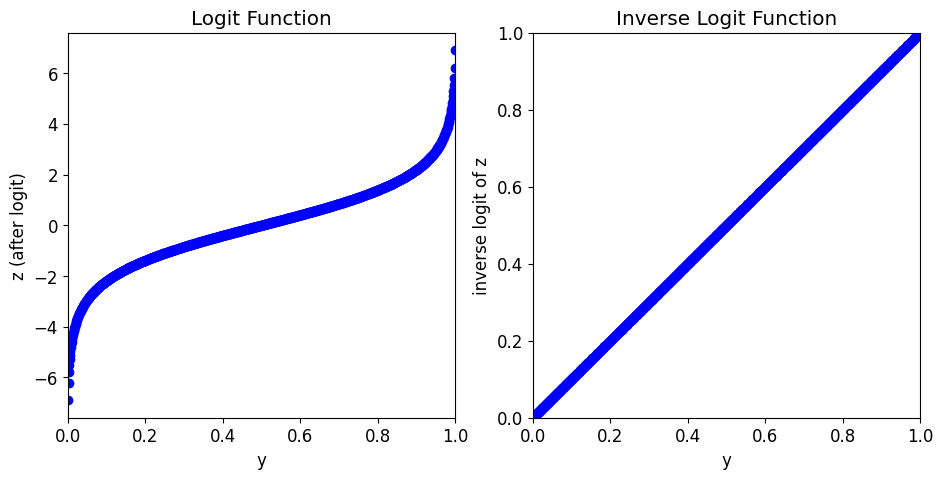

In [28]:
# 03_03_logit

import matplotlib.pyplot as plt
import numpy as np

values = np.arange(0.001, 1, 0.001, dtype=float)
logit = np.log(values / (1 - values))
inverse_logit = np.exp(logit) / (1 + np.exp(logit))

fig, ax = plt.subplots(1, 2, squeeze=False, figsize=(11, 5))

fig1 = ax[0, 0]
fig1.scatter(values, logit, c="blue")
fig1.set_xlabel("y")
fig1.set_ylabel("z (after logit)")
fig1.set_xlim(0, 1)
fig1.set_title("Logit Function")

fig2 = ax[0, 1]
fig2.scatter(values, inverse_logit, c="blue")
fig2.set_xlabel("y")
fig2.set_ylabel("inverse logit of z")
fig2.set_xlim(0, 1)
fig2.set_ylim(0, 1)
fig2.set_title("Inverse Logit Function")
plt.show()


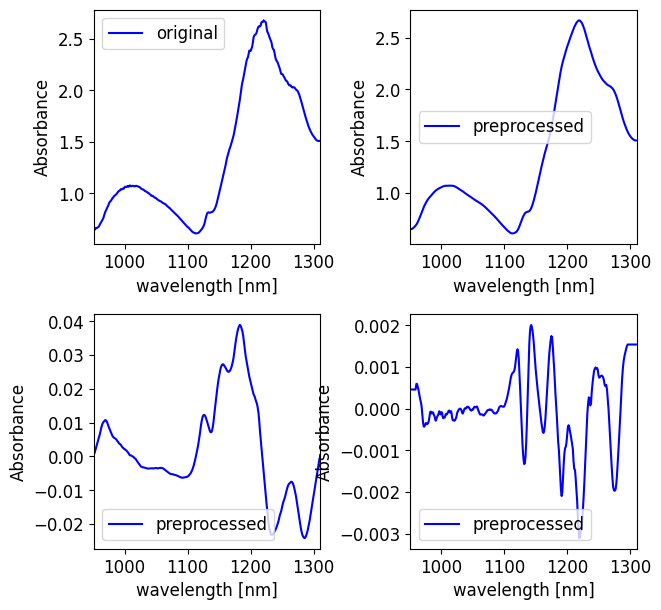

In [29]:
# 03_04_sg

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.signal import savgol_filter

# SG法の設定値
window_length = 21  # 窓枠の数
poly_order = 2  # 多項式の次数
deriv = 0  # 微分次数 (0 は微分なし)
plot_spectra_number = 12  # 表示するスペクトルのサンプル番号 (0, 1, ..., 227)

csv_path = Path("dataset/sample_spectra_dataset.csv")
preprocessed_csv_path0 = Path(
    f"dataset/preprocessed_sample_spectra_dataset_w{window_length}_p{poly_order}_d{deriv}.csv"
)
preprocessed_csv_path1 = Path(
    f"dataset/preprocessed_sample_spectra_dataset_w{window_length}_p{poly_order}_d{1}.csv"
)
preprocessed_csv_path2 = Path(
    f"dataset/preprocessed_sample_spectra_dataset_w{window_length}_p{poly_order}_d{2}.csv"
)

# データセットの読み込み
x = pl.read_csv(csv_path).drop("")
# SG 法
preprocessed_x0 = savgol_filter(
    x.to_numpy(), window_length=window_length, polyorder=poly_order, deriv=deriv
)
preprocessed_x1 = savgol_filter(
    x.to_numpy(), window_length=window_length, polyorder=poly_order, deriv=1
)
preprocessed_x2 = savgol_filter(
    x.to_numpy(), window_length=window_length, polyorder=poly_order, deriv=2
)
# pl.DataFrameに変換してcsvとして保存
preprocessed_x0 = pl.DataFrame(preprocessed_x0, schema=x.schema)
preprocessed_x1 = pl.DataFrame(preprocessed_x1, schema=x.schema)
preprocessed_x2 = pl.DataFrame(preprocessed_x2, schema=x.schema)
preprocessed_x0.with_row_index("").write_csv(preprocessed_csv_path0)
preprocessed_x1.with_row_index("").write_csv(preprocessed_csv_path1)
preprocessed_x2.with_row_index("").write_csv(preprocessed_csv_path2)

# プロット
fig, ax = plt.subplots(2, 2, squeeze=False, figsize=(7, 7))
wave_lengths = np.array(x.columns, dtype="float64")
fig1 = ax[0, 0]
fig1.plot(wave_lengths, x.row(plot_spectra_number), "b-", label="original")
fig1.set_xlabel("wavelength [nm]")
fig1.set_ylabel("Absorbance")
fig1.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig1.legend()

fig2 = ax[0, 1]
fig2.plot(
    wave_lengths,
    preprocessed_x0.row(plot_spectra_number),
    "b-",
    label="preprocessed",
)
fig2.set_xlabel("wavelength [nm]")
fig2.set_ylabel("Absorbance")
fig2.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig2.legend()

fig3 = ax[1, 0]
fig3.plot(
    wave_lengths,
    preprocessed_x1.row(plot_spectra_number),
    "b-",
    label="preprocessed",
)
fig3.set_xlabel("wavelength [nm]")
fig3.set_ylabel("Absorbance")
fig3.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig3.legend()

fig4 = ax[1, 1]
fig4.plot(
    wave_lengths,
    preprocessed_x2.row(plot_spectra_number),
    "b-",
    label="preprocessed",
)
fig4.set_xlabel("wavelength [nm]")
fig4.set_ylabel("Absorbance")
fig4.set_xlim(wave_lengths[0] - 1, wave_lengths[-1] + 1)
fig4.legend()

plt.subplots_adjust(wspace=0.4, hspace=0.3)
plt.show()


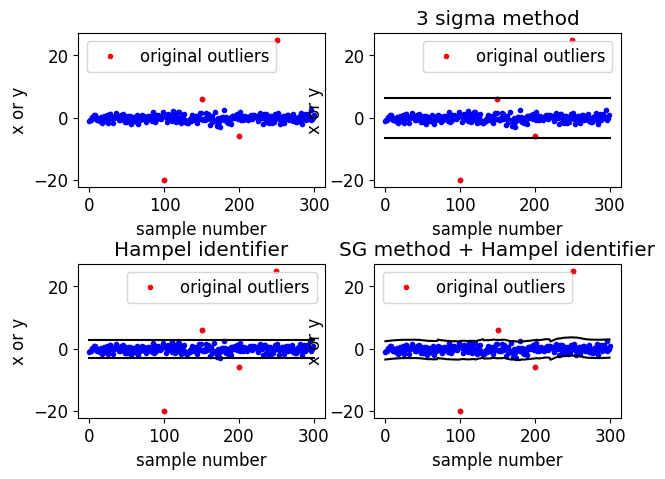

In [30]:
# 03_05_outlier

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# 設定 ここから
type_of_samples = 0  # 仮想サンプルの種類 0:正規乱数、1:時系列
window_length = 61  # SG 法における窓枠の数
poly_order = 2  # SG 法における多項式の次数
deriv = 0  # SG 法における微分次数 (0 は微分なし)
number_of_samples = 300  # 仮想サンプルの数
noise_rate = 8  # SN比

rng = np.random.default_rng(seed=10)

if type_of_samples == 0:
    outliers = [-20, 6, -6, 25]  # 外れ値
    outlier_indices = [100, 150, 200, 250]  # 外れ値のインデックス
    x = rng.standard_normal(number_of_samples)
elif type_of_samples == 1:
    outliers = [1, 3, 10, -2]  # %外れ値
    outlier_indices = [80, 150, 200, 250]  # 外れ値のインデックス
    x = np.sin(np.arange(number_of_samples) * np.pi / 50)
    noise = rng.standard_normal(number_of_samples)
    noise = noise * (x.var() / noise_rate) ** 0.5
    x += noise
x[outlier_indices] = outliers  # 外れ値の追加

fig, ax = plt.subplots(2, 2, squeeze=False, figsize=(7, 5))

fig1 = ax[0, 0]
fig1.plot(x, "b.")  # プロット
fig1.plot(
    outlier_indices, x[outlier_indices], "r.", label="original outliers"
)  # プロット
fig1.set_xlabel("sample number")  # x 軸の名前
fig1.set_ylabel("x or y")  # y 軸の名前
fig1.legend()


# 3 sigma method
upper_3_sigma = x.mean() + 3 * x.std()
lower_3_sigma = x.mean() - 3 * x.std()
fig2 = ax[0, 1]
fig2.plot(x, "b.")
fig2.plot(outlier_indices, x[outlier_indices], "r.", label="original outliers")
fig2.plot([0, len(x)], [upper_3_sigma, upper_3_sigma], "k-")
fig2.plot([0, len(x)], [lower_3_sigma, lower_3_sigma], "k-")
fig2.set_xlabel("sample number")  # x 軸の名前
fig2.set_ylabel("x or y")  # y 軸の名前
fig2.set_title("3 sigma method")
fig2.legend()

# Hampel identifier
upper_hampel = np.median(x) + 3 * 1.4826 * np.median(np.absolute(x - np.median(x)))
lower_hampel = np.median(x) - 3 * 1.4826 * np.median(np.absolute(x - np.median(x)))
fig3 = ax[1, 0]
fig3.plot(x, "b.")
fig3.plot(outlier_indices, x[outlier_indices], "r.", label="original outliers")
fig3.plot([0, len(x)], [upper_hampel, upper_hampel], "k-")
fig3.plot([0, len(x)], [lower_hampel, lower_hampel], "k-")
fig3.set_xlabel("sample number")  # x 軸の名前
fig3.set_ylabel("x or y")  # y 軸の名前
fig3.set_title("Hampel identifier")
fig3.legend()

# SG method + Hampel identifier
preprocessed_x = savgol_filter(
    x, window_length=window_length, polyorder=poly_order, deriv=deriv
)  # SG 法
x_diff = x - preprocessed_x
upper_sg_hampel = (
    preprocessed_x
    + np.median(x_diff)
    + 3 * 1.4826 * np.median(np.absolute(x_diff - np.median(x_diff)))
)
lower_sg_hampel = (
    preprocessed_x
    + np.median(x_diff)
    - 3 * 1.4826 * np.median(np.absolute(x_diff - np.median(x_diff)))
)
fig4 = ax[1, 1]
fig4.plot(x, "b.")
fig4.plot(outlier_indices, x[outlier_indices], "r.", label="original outliers")
fig4.plot(range(len(x)), upper_sg_hampel, "k-")
fig4.plot(range(len(x)), lower_sg_hampel, "k-")
fig4.set_xlabel("sample number")  # x 軸の名前
fig4.set_ylabel("x or y")  # y 軸の名前
fig4.set_title("SG method + Hampel identifier")
fig4.legend()

plt.subplots_adjust(hspace=0.5)
plt.show()  # 以上の設定で描画


In [35]:
# 03_06 demo_elo_pls

import numpy as np
import polars as pl
from dcekit.learning import ensemble_outlier_sample_detection
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV, KFold

# Demonstration of Ensemble Learning Outlier sample detection (ELO)
# https://datachemeng.com/ensembleoutliersampledetection/
# https://www.sciencedirect.com/science/article/abs/pii/S0169743917305919

dataset = pl.read_csv("dataset/numerical_simulation_data.csv").drop("")
y = dataset.get_column("y").to_numpy()
x = dataset.drop("y").to_numpy()

# PLS
max_pls_component_number = 30
pls_components = np.arange(1, min(max_pls_component_number, x.shape[1]) + 1)
cross_validation = KFold(n_splits=2, random_state=9, shuffle=True)
cv_regressor = GridSearchCV(
    PLSRegression(), {"n_components": pls_components}, cv=cross_validation
)
number_of_sub_models = 100
max_iteration_number = 30
outlier_sample_flags = ensemble_outlier_sample_detection(
    cv_regressor,
    x,
    y,
    cv_flag=True,
    n_estimators=number_of_sub_models,
    iteration=max_iteration_number,
    autoscaling_flag=True,
    random_state=0,
)

outlier_sample_flags = pl.DataFrame(outlier_sample_flags)
outlier_sample_flags.columns = ["TRUE if outlier samples"]
outlier_sample_flags.write_csv(
    "dataset/outlier_sample_detection_results.csv", quote_style="never"
)


1 / 30
2 / 30
3 / 30
4 / 30
5 / 30
6 / 30
7 / 30
8 / 30
9 / 30
10 / 30
11 / 30
12 / 30
13 / 30
14 / 30
15 / 30
16 / 30
17 / 30
18 / 30
19 / 30
20 / 30
21 / 30
22 / 30
23 / 30
24 / 30
25 / 30
26 / 30
27 / 30
28 / 30
29 / 30
30 / 30


In [36]:
# 03_07 欠損値の補完(iGMR)

import polars as pl
from dcekit.generative_model import GMR


def calc_interpolated_values(
    model: GMR,
    x_row: list[float],
    normalized_x_row: list[float],
    x: pl.DataFrame,
) -> list[float]:
    """補完値の計算と挿入."""
    if None not in x_row:
        return x_row
    row_series = pl.Series(x_row)
    normalized_row_series = pl.Series(normalized_x_row)
    is_null_series = row_series.is_null()
    is_val_series = row_series.is_not_null()
    mode_of_estimated_mean, *_ = model.predict(
        normalized_row_series.filter(is_val_series).to_frame().transpose(),
        is_val_series.arg_true(),
        is_null_series.arg_true(),
    )

    interpolated_vals = pl.Series(mode_of_estimated_mean[0]) * pl.Series(
        x.std().row(0)
    ).filter(is_null_series) + pl.Series(x.mean().row(0)).filter(is_null_series)

    # Noneをinterpolated_valueに置換
    # for i, j in enumerate(is_null_series.arg_true()):
    return row_series.scatter(is_null_series.arg_true(), interpolated_vals).to_list()


# load dataset
x_wt_nulls = pl.read_csv("dataset/iris_with_nan.csv").drop("")
x = x_wt_nulls.drop_nulls()
# 正規化
normalized_x_wt_nulls = (
    x_wt_nulls
    - x.mean().select(pl.all().extend_constant(pl.all(), n=x_wt_nulls.height - 1))
) / x.std().select(pl.all().extend_constant(pl.all(), n=x_wt_nulls.height - 1))
normalized_x = (
    x - x.mean().select(pl.all().extend_constant(pl.all(), n=x.height - 1))
) / x.std().select(pl.all().extend_constant(pl.all(), n=x.height - 1))
# 元/正規化データのrowデータ(リスト)のDataFrameを作成
rows_of_ori_and_normalized_x_df = x_wt_nulls.select(
    pl.concat_list(pl.all()).alias("x_row")
).hstack(
    normalized_x_wt_nulls.select(pl.concat_list(pl.all()).alias("normalized_x_row"))
)

max_num_of_compo = 20
covariance_types = ["full", "diag", "tied", "spherical"]
for iteration in range(iterations := 10):
    print(f"iteration: {iteration + 1} / {iterations}")
    # グリッドサーチで最適(BICが一番小さい)パラメータを取得.
    bic_values = pl.DataFrame(
        {
            "num_of_compo": [
                num_of_compo
                for _ in covariance_types
                for num_of_compo in range(max_num_of_compo)
            ],
            "cov_type": [
                cov_type
                for cov_type in covariance_types
                for _ in range(max_num_of_compo)
            ],
            "BIC": [
                GMR(num_of_compo + 1, cov_type, random_state=0)
                .fit(normalized_x)
                .bic(normalized_x)
                for cov_type in covariance_types
                for num_of_compo in range(max_num_of_compo)
            ],
        }
    ).sort(pl.col("BIC"))

    # GMM
    model = GMR(
        n_components=bic_values.item(0, "num_of_compo") + 1,
        covariance_type=bic_values.item(0, "cov_type"),
        random_state=0,
    )
    model.fit(normalized_x)

    # interpolation(補完).
    x = (
        rows_of_ori_and_normalized_x_df.select(
            pl.struct(pl.col("x_row"), pl.col("normalized_x_row"))
            .map_elements(
                lambda row_dict, model=model, x=x: calc_interpolated_values(
                    model,
                    row_dict["x_row"],
                    row_dict["normalized_x_row"],
                    x,
                )
            )
            .alias("x_row")
        )
        .with_columns(pl.col("x_row").list.to_struct(fields=x.columns))
        .unnest("x_row")
    )

    # 正規化データを更新
    normalized_x = (
        x - x.mean().select(pl.all().extend_constant(pl.all(), n=x.height - 1))
    ) / x.std().select(pl.all().extend_constant(pl.all(), n=x.height - 1))
    # 元/正規化データのrowデータ(リスト)のDataFrameを更新
    next_normalized_x_rows = normalized_x.select(
        pl.concat_list(pl.all()).alias("normalized_x_row")
    ).get_column("normalized_x_row")
    rows_of_ori_and_normalized_x_df.replace_column(1, next_normalized_x_rows)

# save interpolated dataset
x.with_row_index("", 1).with_columns(
    (pl.lit("sample_") + pl.col("").cast(pl.String)).alias("")
).write_csv("dataset/interpolated_dataset.csv", quote_style="never")

iteration: 1 / 10
iteration: 2 / 10
iteration: 3 / 10
iteration: 4 / 10
iteration: 5 / 10
iteration: 6 / 10
iteration: 7 / 10
iteration: 8 / 10
iteration: 9 / 10
iteration: 10 / 10


In [37]:
# 04_02  同じ値を多くもうt特徴量の削除
import numpy as np
import polars as pl

# 同じ値をもつサンプルの割合で特徴量を削除するためのしきい値
threshold_dup_value_rate = 0.8

x = pl.read_csv("dataset/descriptors_with_logS.csv").drop("", "logS")

print("最初の特徴量の数 :", x.width)
# 同じ値の割合が、threshold_dup_value_rate 以上の特徴量を削除
dup_val_rates = (
    x.select(
        pl.all()
        .value_counts(sort=True, normalize=True, name="dup_rate")
        .first()
        .struct.field("dup_rate")
        .name.keep()
    )
    .with_columns(pl.all() < threshold_dup_value_rate)
    .row(0)
)
x_selected = x[:, dup_val_rates]
print("削除後の特徴量の数 :", x_selected.width)

x_selected.with_row_index("", 1).with_columns(
    (pl.lit("sample_") + pl.col("").cast(pl.String)).alias("")
).write_csv("dataset/x_selected_same_value.csv", quote_style="never")  # 保存


最初の特徴量の数 : 200
削除後の特徴量の数 : 102


同じ値をもつサンプルの割合で削除後の特徴量の数 : 102
相関係数で削除後の特徴量の数 : 80


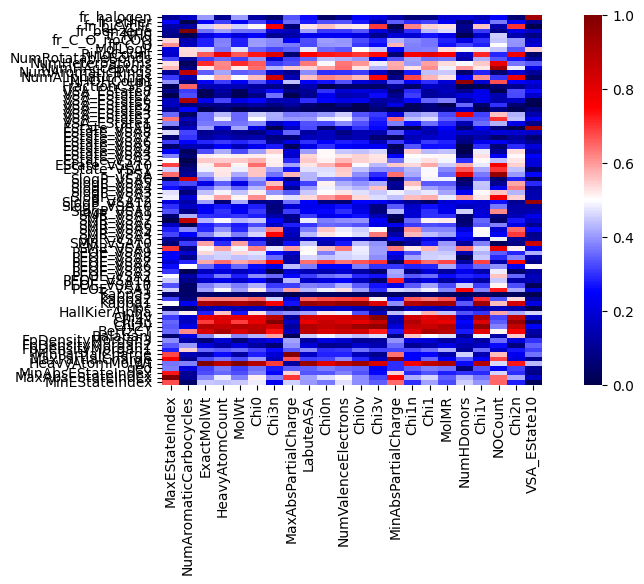

In [1]:
# 04_03 相関係数で特徴量削除

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

x = pl.read_csv("dataset/x_selected_same_value.csv").drop("")
print("同じ値をもつサンプルの割合で削除後の特徴量の数 :", x.width)

# 相関係数を求めて、絶対値に変換
abs_x_corr_df = (
    x.corr(ddof=1)
    .with_columns(pl.all().abs())
    .insert_column(0, pl.Series("", x.columns))
)
# unpivotしてから対角成分を0にする
unpivot_df = abs_x_corr_df.unpivot(
    index="", variable_name="variable", value_name="abs_corr"
).with_columns(
    pl.when(pl.col("").eq(pl.col("variable")))
    .then(0)
    .otherwise(pl.col("abs_corr"))
    .alias("abs_corr")
)

corr_threshold = 0.95
deleted_variables = []
for _ in x.columns:
    biggest_corr_index = unpivot_df["abs_corr"].arg_max()
    # サンプルコードと合わせるためにvar1と2を逆にしている
    var2, var1, biggest_corr = unpivot_df.row(biggest_corr_index)
    if biggest_corr < corr_threshold:
        break
    sum_of_var1_corr = abs_x_corr_df.get_column(var1).sum()
    sum_of_var2_corr = abs_x_corr_df.get_column(var2).sum()
    delete_var = var1 if sum_of_var1_corr >= sum_of_var2_corr else var2
    deleted_variables.append(delete_var)
    unpivot_df = unpivot_df.with_columns(
        pl.when(pl.col("").eq(delete_var) | pl.col("variable").eq(delete_var))
        .then(0)
        .otherwise(pl.col("abs_corr"))
        .alias("abs_corr")
    )

x_selected = x.drop(deleted_variables)
print("相関係数で削除後の特徴量の数 :", x_selected.width)

x_selected.with_row_index("", 1).with_columns(
    (pl.lit("sample_") + pl.col("").cast(pl.String)).alias("")
).write_csv("dataset/x_selected_correlation_deleting.csv", quote_style="never")

similarity_matrix = abs_x_corr_df.select(["", *deleted_variables]).filter(
    pl.col("").is_in(x_selected.columns)
)

# ヒートマップ
sns.heatmap(
    similarity_matrix.to_pandas().set_index(""),
    vmax=1,
    vmin=0,
    cmap="seismic",
    xticklabels=1,
    yticklabels=1,
)
plt.xlim([0, similarity_matrix.width])
plt.ylim([0, similarity_matrix.height])
plt.show()

similarity_matrix.write_csv(
    "dataset/similarity_matrix_correlation_deleting.csv", quote_style="never"
)


同じ値をもつサンプルの割合で削除後の特徴量の数 : 102
相関係数に基づいてクラスタリングした後の特徴量クラスターの数: 82


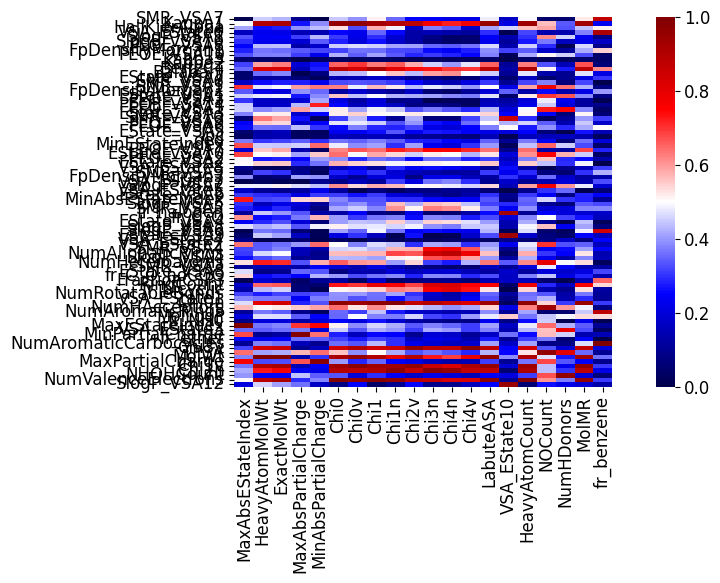

In [1]:
# 04_04 相関係数で特徴量のクラスタリング
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering

x = pl.read_csv("dataset/x_selected_same_value.csv").drop("")
print("同じ値をもつサンプルの割合で削除後の特徴量の数 :", x.width)

# 相関係数を求めて、絶対値に変換
abs_x_corr_df = (
    x.corr(ddof=1)
    .with_columns(pl.all().abs())
    .insert_column(0, pl.Series("", x.columns))
)
# unpivot
unpivot_df = abs_x_corr_df.unpivot(
    index="", variable_name="variable", value_name="abs_corr"
).with_columns(
    (1 / pl.col("abs_corr")).alias("distance_in_x"),
    # 対角成分を10の10乗にする
    pl.when(pl.col("").eq(pl.col("variable")))
    .then(10**10)
    .otherwise(pl.col("abs_corr"))
    .alias("abs_corr"),
)

# 相関係数に基づくクラスタリング
corr_threshold = 0.95
clustering = AgglomerativeClustering(
    n_clusters=None,
    metric="precomputed",
    compute_full_tree=True,
    distance_threshold=1 / corr_threshold,
    linkage="complete",
)

# .clear(abs_x_corr_df.height)
clustering.fit(
    pl.DataFrame([[1] * abs_x_corr_df.height] * abs_x_corr_df.width, orient="col")
    / abs_x_corr_df.drop("")
)
cluster_numbers_df = pl.DataFrame(
    clustering.labels_, schema=["cluster_number"]
).insert_column(0, pl.Series("", x.columns))
cluster_numbers_df.write_csv("dataset/cluster_numbers_correlation.csv")
print(
    f"相関係数に基づいてクラスタリングした後の特徴量クラスターの数: {cluster_numbers_df.n_unique('cluster_number')}"  # noqa: E501
)

# クラスターごとに一つの特徴量を選択
selected_variables = (
    cluster_numbers_df.unique(
        subset="cluster_number", keep="first", maintain_order=True
    )
    .sort("cluster_number")
    .get_column("")
).to_list()
deleted_variables = cluster_numbers_df.filter(
    pl.col("").is_in(selected_variables).not_()
).get_column("")
x_selected = x.select(selected_variables).insert_column(
    0, pl.Series("", [f"sample_{i + 1}" for i in range(x.height)])
)
x_selected.write_csv("dataset/x_selected_correlation_clustering.csv")  # 保存

similarity_matrix = (
    abs_x_corr_df.select(["", *deleted_variables.to_list()])
    .filter(pl.col("").is_in(selected_variables))
    .sort(pl.col("").cast(pl.Enum(selected_variables)))
)
col_list = similarity_matrix.columns
col_list[0] = ""
similarity_matrix.columns = col_list

# ヒートマップ
plt.rcParams["font.size"] = 12
sns.heatmap(
    similarity_matrix.to_pandas().set_index(""),
    vmax=1,
    vmin=0,
    cmap="seismic",
    xticklabels=1,
    yticklabels=1,
)
plt.xlim([0, similarity_matrix.shape[1]])
plt.ylim([0, similarity_matrix.shape[0]])
plt.show()

similarity_matrix.write_csv("dataset/similarity_matrix_correlation_clustering.csv")

# クラスターごとに特徴量を平均化
# クラスター内が1変数のみの場合は何もせず格納
# 複数変数の場合はクラスター毎にデータを分割し、各変数列毎にデータを正規化したあとに、
# 行(サンプル)毎の平均をとったものをx_averagedに格納

x_averaged = pl.DataFrame()
# クラスタ番号でgroup_byするためにtransposeする
x_t = (
    x.transpose(
        include_header=True,
        header_name="variable",
        column_names=[f"sample_{i + 1}" for i in range(x.height)],
    )
    .insert_column(0, cluster_numbers_df.get_column("cluster_number"))
    .sort("cluster_number")
)
for cluster_number, clustered_t_x in x_t.group_by(
    "cluster_number", maintain_order=True
):
    variables = clustered_t_x.get_column("variable")
    clustered_x = clustered_t_x.drop(["cluster_number", "variable"]).transpose(
        column_names=variables
    )
    if clustered_x.width == 1:
        x_averaged.hstack(clustered_x, in_place=True)
    else:
        normalized_c_x = (
            clustered_x
            - clustered_x.mean().select(
                pl.all().extend_constant(pl.all(), n=clustered_x.height - 1)
            )
        ) / clustered_x.std().select(
            pl.all().extend_constant(pl.all(), n=clustered_x.height - 1)
        )
        x_averaged.hstack(
            [
                normalized_c_x.mean_horizontal().rename(
                    f"mean_in_cluster_{cluster_number[0]}"
                )
            ],
            in_place=True,
        )

x_averaged.write_csv("dataset/x_averaged_correlation_clustering.csv")  # 保存
